In [1]:
!poetry add imitation


The following packages are already present in the pyproject.toml and will be skipped:

  • imitation

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.


In [2]:
from functools import partial

from seals import base_envs
from seals.diagnostics.cliff_world import CliffWorldEnv
from stable_baselines3.common.vec_env import DummyVecEnv

import numpy as np

from imitation.algorithms.mce_irl import (
    MCEIRL,
    mce_occupancy_measures,
    mce_partition_fh,
    TabularPolicy,
)
from imitation.data import rollout
from imitation.rewards import reward_nets

env_creator = partial(CliffWorldEnv, height=4, horizon=40, width=7, use_xy_obs=True)
env_single = env_creator()

state_env_creator = lambda: base_envs.ExposePOMDPStateWrapper(env_creator())

# This is just a vectorized environment because `generate_trajectories` expects one
state_venv = DummyVecEnv([state_env_creator] * 4)

In [3]:
env_single.state_space

Discrete(28)

In [4]:
env_single.observation_space

Box(-inf, inf, (2,), float32)

In [5]:
env_single.action_space

Discrete(4)

In [6]:
_, _, pi = mce_partition_fh(env_single)

In [7]:
pi.shape


(40, 28, 4)

In [8]:
_, _, pi = mce_partition_fh(env_single)

_, om = mce_occupancy_measures(env_single, pi=pi)

rng = np.random.default_rng()
expert = TabularPolicy(
    state_space=env_single.state_space,
    action_space=env_single.action_space,
    pi=pi,
    rng=rng,
)

expert_trajs = rollout.generate_trajectories(
    policy=expert,
    venv=state_venv,
    sample_until=rollout.make_min_timesteps(5000),
    rng=rng,
)

print("Expert stats: ", rollout.rollout_stats(expert_trajs))

Expert stats:  {'n_traj': 128, 'return_min': 296.0, 'return_mean': 325.5078125, 'return_std': 9.00346816314934, 'return_max': 334.0, 'len_min': 40, 'len_mean': 40.0, 'len_std': 0.0, 'len_max': 40}


/Users/jackcontro/Library/Caches/pypoetry/virtualenvs/navigation-app-backend-SON1y8JS-py3.10/lib/python3.10/site-packages/imitation/data/types.py:279: UserWarning: tried to wrap <class 'numpy.int64'> as an observation
  warnings.warn(f"tried to wrap {type(obs)} as an observation")


In [9]:
import matplotlib.pyplot as plt
import torch as th


def train_mce_irl(demos, hidden_sizes, lr=0.01, **kwargs):
    reward_net = reward_nets.BasicRewardNet(
        env_single.observation_space,
        env_single.action_space,
        hid_sizes=hidden_sizes,
        use_action=False,
        use_done=False,
        use_next_state=False,
    )

    mce_irl = MCEIRL(
        demos,
        env_single,
        reward_net,
        log_interval=250,
        optimizer_kwargs=dict(lr=lr),
        rng=rng,
    )
    occ_measure = mce_irl.train(**kwargs)

    imitation_trajs = rollout.generate_trajectories(
        policy=mce_irl.policy,
        venv=state_venv,
        sample_until=rollout.make_min_timesteps(5000),
        rng=rng,
    )
    print("Imitation stats: ", rollout.rollout_stats(imitation_trajs))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    env_single.draw_value_vec(occ_measure)
    plt.title("Occupancy for learned reward")
    plt.xlabel("Gridworld x-coordinate")
    plt.ylabel("Gridworld y-coordinate")
    plt.subplot(1, 2, 2)
    _, true_occ_measure = mce_occupancy_measures(env_single)
    env_single.draw_value_vec(true_occ_measure)
    plt.title("Occupancy for true reward")
    plt.xlabel("Gridworld x-coordinate")
    plt.ylabel("Gridworld y-coordinate")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    env_single.draw_value_vec(
        reward_net(th.as_tensor(env_single.observation_matrix), None, None, None)
        .detach()
        .numpy()
    )
    plt.title("Learned reward")
    plt.xlabel("Gridworld x-coordinate")
    plt.ylabel("Gridworld y-coordinate")
    plt.subplot(1, 2, 2)
    env_single.draw_value_vec(env_single.reward_matrix)
    plt.title("True reward")
    plt.xlabel("Gridworld x-coordinate")
    plt.ylabel("Gridworld y-coordinate")
    plt.show()

    return mce_irl

In [10]:
expert_trajs[0]

TrajectoryWithRew(obs=array([ 0,  8, 16, 17, 18,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6, 13]), acts=array([3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]), infos=array([{'old_state': 0, 'new_state': 8, 'TimeLimit.truncated': False},
       {'old_state': 8, 'new_state': 16, 'TimeLimit.truncated': False},
       {'old_state': 16, 'new_state': 17, 'TimeLimit.truncated': False},
       {'old_state': 17, 'new_state': 18, 'TimeLimit.truncated': False},
       {'old_state': 18, 'new_state': 5, 'TimeLimit.truncated': False},
       {'old_state': 5, 'new_state': 6, 'TimeLimit.truncated': False},
       {'old_state': 6, 'new_state': 6, 'TimeLimit.truncated': False},
       {'old_state': 6, 'new_state': 6, 'TimeLimit.truncated': False},
       {'old_state': 6, 'new_state': 6, 'TimeLimit.truncated': False},

--------------------------
| grad_norm   | 95.5     |
| iteration   | 0        |
| linf_delta  | 32.7     |
| weight_norm | 11.2     |
--------------------------
--------------------------
| grad_norm   | 0.869    |
| iteration   | 250      |
| linf_delta  | 0.22     |
| weight_norm | 18.4     |
--------------------------
--------------------------
| grad_norm   | 1.39     |
| iteration   | 500      |
| linf_delta  | 0.22     |
| weight_norm | 25.9     |
--------------------------
--------------------------
| grad_norm   | 3.36     |
| iteration   | 750      |
| linf_delta  | 0.22     |
| weight_norm | 44.3     |
--------------------------


/Users/jackcontro/Library/Caches/pypoetry/virtualenvs/navigation-app-backend-SON1y8JS-py3.10/lib/python3.10/site-packages/imitation/data/types.py:279: UserWarning: tried to wrap <class 'numpy.int64'> as an observation
  warnings.warn(f"tried to wrap {type(obs)} as an observation")


Imitation stats:  {'n_traj': 128, 'return_min': 289.0, 'return_mean': 323.703125, 'return_std': 10.296661606286525, 'return_max': 334.0, 'len_min': 40, 'len_mean': 40.0, 'len_std': 0.0, 'len_max': 40}


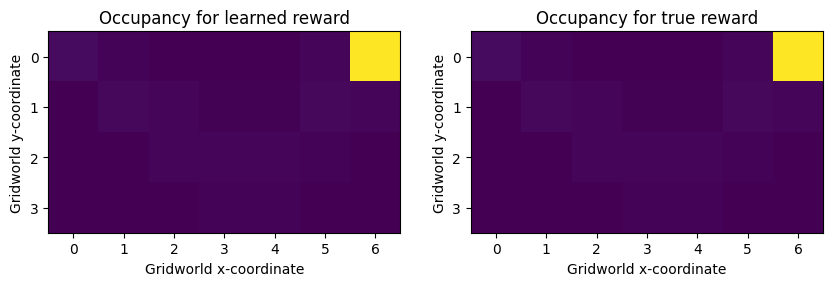

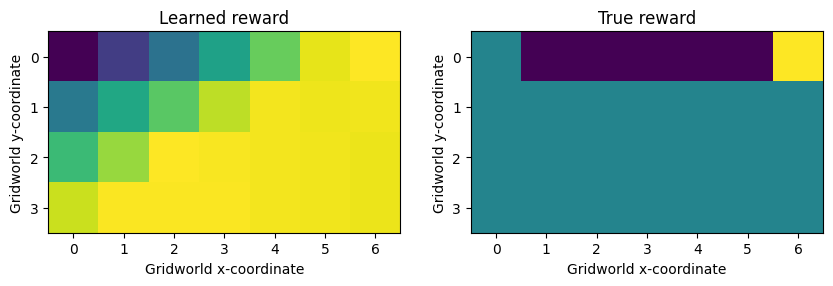

In [11]:
mce_irl_from_trajs = train_mce_irl(expert_trajs[0:10], hidden_sizes=[256])

In [12]:
pi

array([[[1.66941249e-05, 1.11138376e-04, 3.51004687e-04, 9.99521163e-01],
        [3.09465993e-10, 2.07696147e-04, 6.50672106e-09, 9.99792297e-01],
        [2.04361086e-14, 1.32687739e-04, 1.83791807e-10, 9.99867312e-01],
        ...,
        [9.05904862e-10, 9.99983271e-01, 2.12579248e-09, 1.67254852e-05],
        [1.10436179e-04, 9.99839546e-01, 1.66628233e-05, 3.33548264e-05],
        [4.99554230e-01, 5.00420720e-01, 8.35542665e-06, 1.66941249e-05]],

       [[1.66941249e-05, 1.11138376e-04, 3.51004687e-04, 9.99521163e-01],
        [3.09465993e-10, 2.07696147e-04, 6.50672106e-09, 9.99792297e-01],
        [2.04361086e-14, 1.32687739e-04, 1.83791807e-10, 9.99867312e-01],
        ...,
        [9.05904862e-10, 9.99983271e-01, 2.12579248e-09, 1.67254852e-05],
        [1.10436179e-04, 9.99839546e-01, 1.66628233e-05, 3.33548264e-05],
        [4.99554230e-01, 5.00420720e-01, 8.35542665e-06, 1.66941249e-05]],

       [[1.66941249e-05, 1.11138376e-04, 3.51004687e-04, 9.99521163e-01],
        

In [13]:
env_single.reward_matrix

array([ -1., -10., -10., -10., -10., -10.,  10.,  -1.,  -1.,  -1.,  -1.,
        -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
        -1.,  -1.,  -1.,  -1.,  -1.,  -1.])

Trying to figure out how to make this work

In [14]:
import numpy as np
example_reward = np.array([
    [1, 0, 0],
    [1, 1, 0],
    [1, 1, 1]
])


In [15]:
import numpy as np

observations = np.array([
    np.array([
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
    ], dtype=np.int32),
    np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
    ], dtype=np.int32),
    np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
    ], dtype=np.int32)
])

print(observations)


[[[1 0 0]
  [1 0 0]
  [1 0 0]]

 [[1 0 0]
  [0 1 0]
  [0 0 1]]

 [[1 0 0]
  [0 1 0]
  [0 1 0]]]


In [16]:
expert_trajs

[TrajectoryWithRew(obs=array([ 0,  8, 16, 17, 18,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6, 13]), acts=array([3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]), infos=array([{'old_state': 0, 'new_state': 8, 'TimeLimit.truncated': False},
        {'old_state': 8, 'new_state': 16, 'TimeLimit.truncated': False},
        {'old_state': 16, 'new_state': 17, 'TimeLimit.truncated': False},
        {'old_state': 17, 'new_state': 18, 'TimeLimit.truncated': False},
        {'old_state': 18, 'new_state': 5, 'TimeLimit.truncated': False},
        {'old_state': 5, 'new_state': 6, 'TimeLimit.truncated': False},
        {'old_state': 6, 'new_state': 6, 'TimeLimit.truncated': False},
        {'old_state': 6, 'new_state': 6, 'TimeLimit.truncated': False},
        {'old_state': 6, 'new_state': 6, 'TimeLimit.truncat

In [18]:
type(expert_trajs[0])

imitation.data.types.TrajectoryWithRew

In [22]:
expert_trajs



TrajectoryWithRew(obs=array([ 0,  8, 16, 17, 18,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6, 13]), acts=array([3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]), infos=array([{'old_state': 0, 'new_state': 8, 'TimeLimit.truncated': False},
       {'old_state': 8, 'new_state': 16, 'TimeLimit.truncated': False},
       {'old_state': 16, 'new_state': 17, 'TimeLimit.truncated': False},
       {'old_state': 17, 'new_state': 18, 'TimeLimit.truncated': False},
       {'old_state': 18, 'new_state': 5, 'TimeLimit.truncated': False},
       {'old_state': 5, 'new_state': 6, 'TimeLimit.truncated': False},
       {'old_state': 6, 'new_state': 6, 'TimeLimit.truncated': False},
       {'old_state': 6, 'new_state': 6, 'TimeLimit.truncated': False},
       {'old_state': 6, 'new_state': 6, 'TimeLimit.truncated': False},